<a href="https://colab.research.google.com/github/samiha-mahin/A_Deep_Learning_Repo/blob/main/DAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DAN (Deep & Cross Network)**

---

# What is DAN (Deep & Cross Network)?

**DAN** stands for **Deep & Cross Network**. It's a neural network architecture designed to efficiently model both **explicit feature interactions** (like in factorization machines) and **deep nonlinear feature interactions**.

---

# Why DAN?

* Traditional models like **logistic regression** capture only **linear relationships**.
* Deep neural networks capture complex, **nonlinear feature interactions** but sometimes fail to explicitly model low-order feature crosses.
* Feature crossing (interactions between features) is very important in applications like recommendation systems and ads.
* DAN combines a **cross network** (which explicitly models bounded-degree feature crosses) with a **deep network** (which models higher-order, nonlinear interactions).

---

# Architecture of DAN

DAN consists of two main parts, working in parallel:

### 1. Cross Network (Explicit Crosses)

* This network models **explicit feature crosses** of bounded degree.
* Given input $x_0$, the cross network outputs layers $x_1, x_2, ..., x_L$ where each layer is:

$$
x_{l+1} = x_0 \cdot (x_l^T w_l) + b_l + x_l
$$

* Here:

  * $x_0$ is the original input vector.
  * $w_l$ is a learnable weight vector.
  * $b_l$ is a bias.
* This operation explicitly models cross terms like $x_i x_j$, $x_i x_j x_k$ etc., in a controlled way.

### 2. Deep Network (Nonlinear Interactions)

* A standard feed-forward neural network with several fully connected layers and nonlinear activations.
* It captures **complex, high-order feature interactions** implicitly.

### 3. Concatenation and Output

* Outputs of the Cross Network and Deep Network are concatenated.
* Followed by a final linear layer and activation for prediction.

---

# Why is this useful?

* Efficiently captures both **low-degree explicit feature crosses** and **complex nonlinear interactions**.
* Works well for tabular data, especially in CTR prediction, recommendation, and advertising.

---

# Example Use Case

Suppose you have features like:

* User age
* User gender
* Ad category
* Device type

You want to predict if a user will click an ad (binary classification).

* Cross network might explicitly model interactions like (User age) × (Ad category).
* Deep network might model complex nonlinear patterns across all features.
* DAN combines these for better predictive power.

---


# Summary

| Aspect          | Explanation                                          |
| --------------- | ---------------------------------------------------- |
| Purpose         | Model explicit and implicit feature interactions     |
| Cross Network   | Models low-degree explicit feature crosses           |
| Deep Network    | Models nonlinear, high-order interactions            |
| Combined Output | Concatenation for final prediction                   |
| Use Cases       | CTR prediction, recommendation systems, tabular data |

---



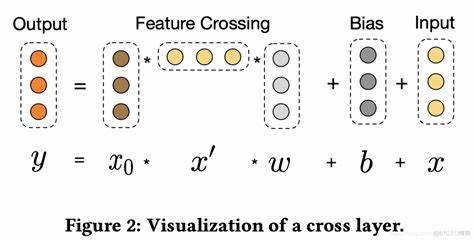

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, Model

class CrossLayer(layers.Layer):
    def __init__(self, input_dim):
        super().__init__()
        self.w = self.add_weight(shape=(input_dim,), initializer='random_normal', trainable=True)
        self.b = self.add_weight(shape=(input_dim,), initializer='zeros', trainable=True)

    def call(self, x0, x):
        xw = tf.reduce_sum(x * self.w, axis=1, keepdims=True)
        return x0 * xw + self.b + x

class DeepCrossNetwork(Model):
    def __init__(self, input_dim):
        super().__init__()
        self.cross1 = CrossLayer(input_dim)
        self.cross2 = CrossLayer(input_dim)
        self.dense1 = layers.Dense(64, activation='relu')
        self.dense2 = layers.Dense(32, activation='relu')
        self.output_layer = layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        x0 = inputs
        x = self.cross1(x0, x0)
        x = self.cross2(x0, x)
        deep_out = self.dense1(x0)
        deep_out = self.dense2(deep_out)
        combined = tf.concat([x, deep_out], axis=1)
        return self.output_layer(combined)


In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score

# Load Titanic data (example)
df = pd.read_csv('titanic.csv')

# Preprocessing (simple example)
df['Age'].fillna(df['Age'].median(), inplace=True)
df['Fare'].fillna(df['Fare'].median(), inplace=True)
df['Embarked'].fillna('S', inplace=True)

# Select features and target
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
X = df[features]
y = df['Survived'].values

# Encode categorical variables
X = pd.get_dummies(X, columns=['Sex', 'Embarked'])

# Scale numerical features
scaler = StandardScaler()
for col in ['Age', 'Fare']:
    X[col] = scaler.fit_transform(X[[col]])

X = X.values.astype(np.float32)

# Train-test split
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Define your DAN model (as shared earlier)...

input_dim = X_train.shape[1]
model = DeepCrossNetwork(input_dim=input_dim)

# Compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train
model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=50, batch_size=32)

# Predict and evaluate
y_pred = (model.predict(X_valid) > 0.5).astype(int)
print("Validation Accuracy:", accuracy_score(y_valid, y_pred))


Epoch 1/50


/tmp/ipython-input-5-2066763222.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].fillna(df['Age'].median(), inplace=True)
/tmp/ipython-input-5-2066763222.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)'

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.6403 - loss: 0.6495 - val_accuracy: 0.6927 - val_loss: 0.5696
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7402 - loss: 0.5296 - val_accuracy: 0.7765 - val_loss: 0.5260
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7738 - loss: 0.5079 - val_accuracy: 0.8045 - val_loss: 0.5017
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7959 - loss: 0.4639 - val_accuracy: 0.8045 - val_loss: 0.4868
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8196 - loss: 0.4394 - val_accuracy: 0.8045 - val_loss: 0.4773
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7934 - loss: 0.4599 - val_accuracy: 0.8156 - val_loss: 0.4686
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7968 - loss: 0.4360 - val_accuracy: 0.8156 - val_loss: 0.4640
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8288 - loss: 0.4040 - val_accuracy: 0.8101 - val_loss: 0.4582
Ep